In [30]:
import scipy.stats as stats
import pickle
from dotmap import DotMap
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import iqr
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from numpy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import copy
from collections import defaultdict
from tabulate import tabulate
import pandas as pd

import seaborn as sns

# sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman'], 'font.serif': 8})
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [31]:
def f_mean(x):
    return str(round(np.mean(list(x)), 4)*100) + '+/-' + str(np.std(list(x)).round(2))

import numpy as np
import scipy.stats as st

# 0·95 (0·94–0·95)

def f_std(d):
    a, b = st.t.interval(alpha=0.95, df=len(d)-1, loc=np.mean(d), scale=st.sem(d)) 
    a = np.mean(d) - np.std(d)
    b = np.mean(d) + np.std(d)
    return str(round(np.mean(list(d)), 2)) + f' [{round(a, 2)}-{round(b, 2)}]'

def f_ci(d):
    a, b = st.t.interval(alpha=0.95, df=len(d)-1, loc=np.mean(d), scale=st.sem(d)) 
    return str(round(np.mean(list(d)), 4)) + f' [{round(a, 4)}-{round(b, 4)}]'
    # return str(round(np.mean(list(d)), 2)) + '+/-' + f"{round(b - (a+b)/2, 2)}"
    
def f_iqr(d):
    m = np.mean(list(d))
    a, b = m - iqr(d), m + iqr(d)
    return str(round(np.mean(list(d)), 2)) + f' [{round(a, 2)}-{round(b, 2)}]'

In [32]:
# boot_conf_intervals_ml.py just concatenates the gists referenced below

# Example usage: 
# from boot_conf_intervals_ml import ci # enough to calc conf intervals
#
# But for more detailed usage like in the article, you might want:
# from boot_conf_intervals_ml import ci, data_args_to_df, make_boot_df \
#    , specificity_score, raw_metric_samples, metric_boot_histogram \
#    #don't need:#     , metrics_from_df, metrics_from_data_args
         
# https://gist.github.com/DavidRosen/356fd5bc7fe74d444c9e971680fadd5e
import numpy as np
import pandas as pd
import re
def data_args_to_df(*data_args):
    return pd.DataFrame( { arg.name if hasattr(arg,'name') else str(i) :
                           np.array(arg)   for i,arg in enumerate(data_args)
                         }# end of dict comprehen.; np.array() removes index
                       )
def make_boot_df(dforig):
    """Returns one boot sample dataframe, same shape as dforig
    """
    return dforig.sample(frac=1,replace=True).reset_index(drop=True)

# https://gist.github.com/DavidRosen/20dc3143d1354eba911a995fb75f81d7
from sklearn import metrics
def specificity_score(true, pred, **kwargs):
    return metrics.recall_score(1-pd.Series(true), 1-pd.Series(pred), **kwargs)
specificity_score.__name__ = "Specificity (Recall of −ve)"

def metrics_from_df(metrics, df, **metric_kwargs):
    data_args=[col_as_arg for (colname,col_as_arg) in df.items()]
    return metrics_from_data_args(metrics, *data_args, **metric_kwargs)
def metrics_from_data_args(metrics, *data_args, **metric_kwargs):
    if callable(metrics): metrics=[metrics] # single metric func to list of
    return   [m(*data_args, **_kws_this_metric(m,**metric_kwargs)) for m in 
      metrics]#end of list comprehension of all metrics applied to *data_args

def _get_default_keywords(metric): # how to make it work on specificity_score??
    return metric.__wrapped__.__kwdefaults__ if \
      ( hasattr(metric,"__wrapped__") and
        hasattr(metric.__wrapped__,"__kwdefaults__") and
        isinstance(metric.__wrapped__.__kwdefaults__, dict) 
      ) else dict() # empty dict if no __kwdefaults__ dict
def _kws_this_metric(metric,**metric_kwargs): # kwargs this metric accepts
    return { k: metric_kwargs[k] for k in # set intersection of keys:
             metric_kwargs.keys() & _get_default_keywords(metric).keys() 
           }# end of dict comprehension to convert keys set back to dict
def _metric_name(metric):
    name=re.sub(' score$','',metric.__name__.replace('_',' '))
    return name.title() if name.lower()==name else name

# https://gist.github.com/DavidRosen/dd79e5e46ae53c2bde63c8a07460a044
from tqdm import trange
DFLT_NBOOTS=1000
def raw_metric_samples(metrics, *data_args, nboots=DFLT_NBOOTS, sort=False,
       **metric_kwargs):
    """Return dataframe containing metric(s) for nboots boot sample datasets.
    metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    if callable(metrics): metrics=[metrics] # single metric func to list of
    metrics=list(metrics) # in case it is a generator
    dforig=data_args_to_df(*data_args)
    res=pd.DataFrame( { b: metrics_from_df(metrics, dfboot, **metric_kwargs)
                           for b,dfboot in # generator expr, not huge df list!
                           ((b,make_boot_df(dforig)) for b in trange(nboots))
                           if dfboot.iloc[:,0].nunique()>1 # >1: log loss, roc
                      }, index=[_metric_name(m) for m in metrics]
                    ) # above { b: ... for b,dfboot in... } is dict comprehen.
    res.index.name="Metric (class 1 +ve)"
    return res.apply(lambda row: np.sort(row), axis=1) if sort else res

# https://gist.github.com/DavidRosen/74c35f12ead6a984649f7d6efb9895d2
import matplotlib, matplotlib.ticker as mtick
DFLT_QUANTILES=[0.025,0.975]
def metric_boot_histogram( metric, *data_args, quantiles=DFLT_QUANTILES, 
                           nboots=DFLT_NBOOTS, **metric_kwargs
                         ):
    point = metric(*data_args, **metric_kwargs)
    data = raw_metric_samples(metric, *data_args, **metric_kwargs).transpose()
    (lower, upper) = data.quantile(quantiles).iloc[:,0]
    import seaborn; seaborn.set_style('whitegrid')  #optional
    matplotlib.rcParams["figure.dpi"] = 300
    ax = data.hist(bins=50, figsize=(5, 2), alpha=0.4)[0][0]
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    for x in lower, point, upper:
        ax.plot([x, x],[0, 30], lw=2.5)

# https://gist.github.com/DavidRosen/feddfcc657110b56cc6e4a49e20fa4db
def ci( metrics, *data_args, quantiles=DFLT_QUANTILES, 
        nboots=DFLT_NBOOTS, **metric_kwargs
      ):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    quantiles : [upper,lower] if for 1 CI (dflt is for 95% 2-tail)
    nboots : number of bootstrap samples drawn from data (dflt 500)
    metric_kwargs : each metric gets any KW's it accepts optionally
    """
    if callable(metrics): metrics=[metrics] # single metric func to list of
    metrics=list(metrics) # in case it is a generator [expr]
    result=raw_metric_samples(metrics, *data_args, nboots=nboots, sort=False,
              **metric_kwargs)
    resboots=result.shape[1]
    if resboots<nboots:  # results may be biased if too many were dropped
        print( f'Note: {nboots-resboots} boot sample datasets dropped \n'
               f'(out of {nboots}) because all vals were same in 1st data arg.'
             ) # only 1st data arg because it is probably true target arg
    result=result.apply(lambda row: row.quantile(quantiles),axis=1)
    result.columns=[f'{q*100}%ile' for q in quantiles]
    result.columns.name=f"{resboots} Boot Samples"
    result.insert( 0, "Point Estim", metrics_from_data_args(metrics, 
                                *data_args, **metric_kwargs)
                 ) # inserted (in place) all point estims as first col
    return result


In [33]:
def get_95ci(d):
    a, b = st.t.interval(alpha=0.95, df=len(d)-1, loc=np.mean(d), scale=st.sem(d))
    return np.mean(d) - a

In [34]:
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import confusion_matrix

def get_alls(y_true, y_predictions):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predictions).ravel()
    sensitivity = tp / (tp + fn) # sensitivity, recall, hit rate, or true positive rate (TPR)
    specificity = tn / (tn + fp) # specificity, selectivity or true negative rate (TNR)
    precision = tp / (tp + fp) # precision or positive predictive value (PPV)
    npv = tn / (tn + fn) # negative predictive value (NPV)
    fnr = fn / (fn + tp) # miss rate or false negative rate (FNR)
    tpr = 1 - fnr
    fpr = fp / (fp + tn)# fall-out or false positive rate (FPR)
    tnr = 1 - fpr
    fdr = fp / (fp + tp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    bal_acc = (tpr + tnr) / 2
    f1score = 2 * tp / (2 * tp + fp + fn)    
    class_metrics = {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "ppv": precision,
        "npv": npv,
        "fnr": fnr,
        "tpr": tpr,
        "fpr": fpr,
        "tnr": tnr,
        "fdr": fdr,
        "acc": acc,
        "bal_acc": bal_acc,
        "f1score": f1score, 
    }
    for prevalence in [0.1, 0.01, 0.001]:
        ppv = sensitivity * prevalence / (sensitivity * prevalence + (1-specificity) * (1 - prevalence))
        npv = specificity * (1 - prevalence) / (specificity * (1 - prevalence) + (1-sensitivity) * prevalence)
        # class_metrics[f'ppv_{prevalence}'] = ppv
        # class_metrics[f'npv_{prevalence}'] = ppv
        
    return class_metrics
    print ( tn, fp, fn, tp )
    print ("specificity", specificity)
    print ("sensitivity", sensitivity)
    print ("precision", precision)
    print ("npv", npv)
    print ("fnr", fnr)
    print ("tpr", tpr)
    print ("fpr", fpr)
    print ("tnr", tnr)
    print ("fdr", fdr)
    print ("acc", acc)
    print ("bal_acc", bal_acc)
    print ("f1score", f1score)
    

def cm_analysis(y_true, y_pred, filename, labels, classes, ax, cmap="Blues", ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    # fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=False, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap=cmap)
    return ax
    # return fig
    # plt.savefig(filename,  bbox_inches='tight')

In [35]:
def plot_auc_roc(full_list, n_classes, class_label, ax, show=True, addition='', palette_progression=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    mean_tpr = dict()
    mean_fpr = dict()
    mean_auc = dict()
    all_means = defaultdict(list)
    for k in range(n_classes[0], n_classes[1]):
        if class_label.get(k, None) is None:
            continue
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for preds, label in full_list[k]:
            # preds = lr.fit(X_clinical.iloc[train], Y_clinical.iloc[train]).predict_proba(X_clinical.iloc[test])[:,k]
            # label = [1 if int(j) == (k+2) else 0 for j in Y_clinical.iloc[test]] #2,3,4
            fpr, tpr, _ = metrics.roc_curve(label, preds)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
        print ("AUCS", f_ci(aucs), f_iqr(aucs))
        class_name = class_label[k]# 'PDvec1' if k+2==2 else 'PDvec2' if k+2==3 else 'PDvec3' if k+2==4 else 'SWEDD' if k+2==5 else 'NA'   
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        all_means[class_name].append(mean_auc)
        std_auc = np.std(aucs)
        if show:
            if std_auc > 0:
                ax.plot(mean_fpr, mean_tpr,
                 label=r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc),
                 lw=2, alpha=.9, color=palette_progression[class_label[k]])
            else:
                ax.plot(mean_fpr, mean_tpr,
                 label=r'{0} mean ROC (AUC = {1:0.2f})'.format(class_name, mean_auc, std_auc),
                 lw=2, alpha=.9, color=palette_progression[class_label[k]])
        std_tpr = np.std(tprs, axis=0)
        # std_tpr = get_95ci(tprs)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        if show:
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1)
    if not show:
        return pd.DataFrame(all_means)
    # ax.figure(1, figsize=(9, 5))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.025, 1.025])
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('{}'.format(addition))
    ax.legend()
    # plt.show()
    return pd.DataFrame(all_means)

In [36]:
def bootstrap_plot_auc_roc(full_list, n_classes, class_label, ax, show=True, addition='', palette_progression=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    mean_tpr = dict()
    mean_fpr = dict()
    mean_auc = dict()
    all_means = defaultdict(list)
    for k in range(n_classes[0], n_classes[1]):
        if class_label.get(k, None) is None:
            continue
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        preds, label = full_list[k]
        # cix = ci(met, label, preds, nboots=10000)# .style.format('{:.2%}')  
        met=[ metrics.roc_auc_score, metrics.roc_curve]
        Z_n = raw_metric_samples(met, label, preds, nboots=1000)
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        for i in range(len(Z_n.columns)):
            tprs.append(interp(mean_fpr, Z_n.loc["Roc Curve"][i][0], Z_n.loc["Roc Curve"][i][1]))
            tprs[-1][0] = 0.0
            
        
        
        fpr, tpr, _ = metrics.roc_curve(label, preds)
        mean_tpr = interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
        mean_auc = auc(fpr, tpr)
        
        temp = tprs - mean_tpr
        tprs_upper = mean_tpr - np.quantile(temp, 0.975)
        tprs_lower = mean_tpr - np.quantile(temp, 0.025)
        
        
        
        # tprs_upper = np.quantile(tprs, 0.025, axis=0)
        # tprs_lower = np.quantile(tprs, 0.975, axis=0)
        
        tprs_lower[-1] = 1.0
        tprs_upper[-1] = 1.0
        tprs_lower[0] = 0.0
        tprs_upper[0] = 0.0
        
        
        
        
        
        
        
        # mean_tpr = np.quantile(tprs, 0.5, axis=0)
        # mean_tpr = np.mean(tprs, axis=0)
        # mean_tpr[-1] = 1.0
        # ci_lower_auc = np.quantile(Z_n.loc['Roc Auc'], 0.025)
        # ci_upper_auc = np.quantile(Z_n.loc['Roc Auc'], 0.975)
        # mean_auc = np.mean(Z_n.loc['Roc Auc'])
                
        class_name = class_label[k]
        ci_lower_auc = auc(mean_fpr, tprs_upper)
        ci_upper_auc = auc(mean_fpr, tprs_lower)
        print ('mean auc', mean_auc, 'roc auc', metrics.roc_auc_score(label, preds), ci_lower_auc, ci_upper_auc)

        all_means[class_name].append(mean_auc)
        std_auc = 1 # ci_upper_auc - mean_auc
        print (mean_auc, std_auc, ci_lower_auc)
        if show:
            if std_auc > 0:
                ax.plot(mean_fpr, mean_tpr,
                 label=r'{0} mean ROC (AUC = {1:0.2f} (95% CI {2:0.2f}-{3:0.2f})'.format(class_name, mean_auc, ci_lower_auc, ci_upper_auc),
                 lw=2, alpha=.9, color=palette_progression[class_label[k]])
            
        # std_tpr = np.std(tprs, axis=0)
        # std_tpr = get_95ci(tprs)
        # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        if show:
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1)
            
    # if not show:
    #    return pd.DataFrame(all_means)
    # ax.figure(1, figsize=(9, 5))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.025, 1.025])
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('{}'.format(addition))
    ax.legend(loc='lower right')
    # plt.show()
    # return pd.DataFrame(all_means)

In [37]:
from pathlib import Path
organized_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03_30")
data_all = pd.read_parquet(organized_generated_dir / 'combinedData.parquet.gzip')
data = data_all[data_all['ukbb_id_nih'].str.contains('20252_2_0')].copy().set_index('eid')

In [38]:
s = data[f'Date_of_PD'] - data['Date_of_attending_assessment_centre']

In [39]:
s[s>0].shape

(46,)

In [40]:
s[s<=0].shape

(48,)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.17it/s]


mean auc 0.9445277587298375 roc auc 0.9445277587298375 0.9303600432206698 0.9553212077763292
0.9445277587298375 1 0.9303600432206698
Dthreshold 0.4391937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1051.78it/s]


mean auc 0.633661650534382 roc auc 0.633661650534382 0.5658166405766367 0.7054592271371263
0.633661650534382 1 0.5658166405766367
Dthreshold 0.77635056


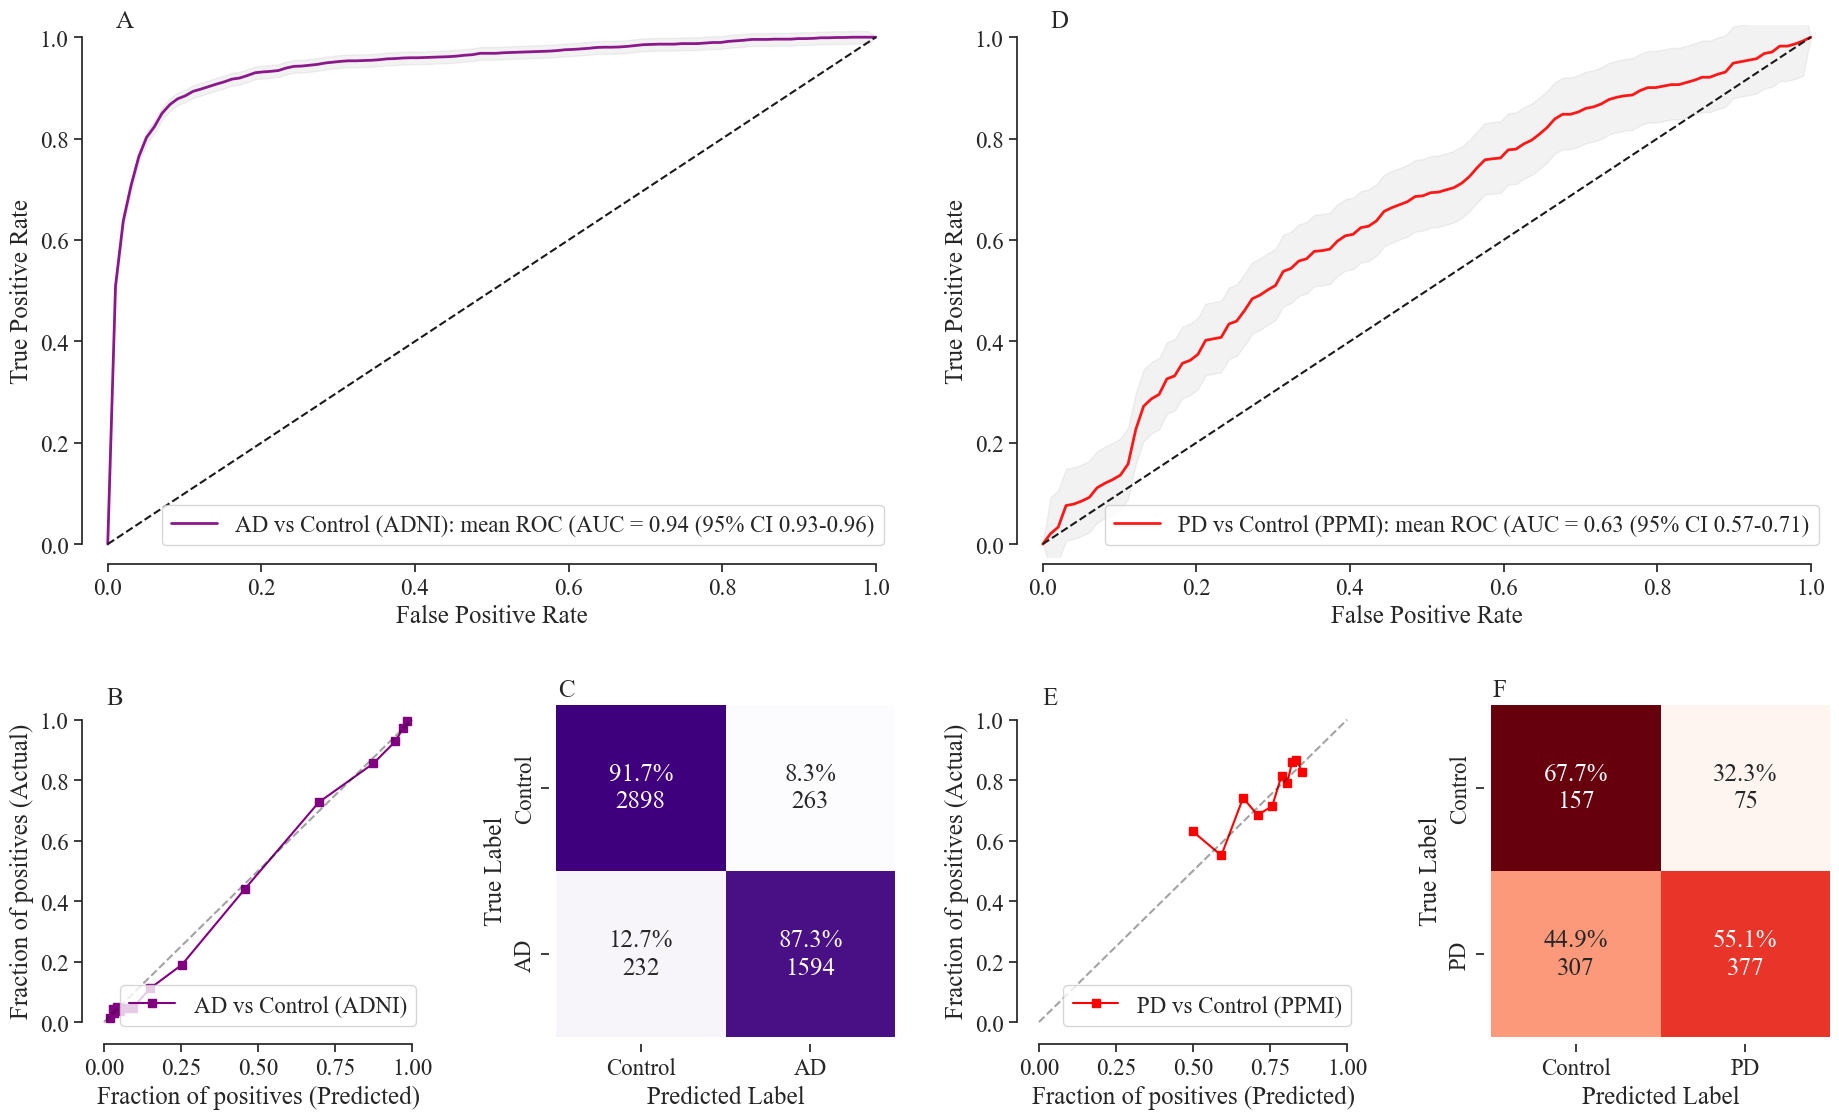

In [41]:
sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

mpl.rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({"savefig.format": 'png'})
fig, axd = plt.subplot_mosaic([['upper1', 'upper1', 'upper2', 'upper2'], ['bottom left1', 'bottom right1', 'bottom left2', 'bottom right2']],
                              gridspec_kw=dict(height_ratios=[2.4*0.8, 1.5*0.8]), figsize=(24*0.8, 15*0.8))
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)

ensembled_prediction = pd.read_csv("data/ad_ensembled_prediction.csv")
full_list_d = []
# for fold in ['fold1', 'fold2', 'fold3']:
#     temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
#     full_list_d[0].append((temp['ensemble-y_pred1'].values, temp['y_true'].values))
    
full_list_d.append((ensembled_prediction['ensemble-y_pred1'].values, ensembled_prediction['y_true'].values))
y_test = ensembled_prediction['y_true'].values
y_probas = ensembled_prediction[['ensemble-y_pred0', 'ensemble-y_pred1']].values

disease = 'ALL_DEMENTIA'
duration_col = f"daysFromDiagnosis_image_taken_{disease}"
data[duration_col] = data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']
data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values
input_data = data[~(data[duration_col] >= 0)].copy()
temp_input_data = data.copy()
event_subjects = temp_input_data[temp_input_data[duration_col] <= 0].index
event_subjects_data = temp_input_data.loc[event_subjects].copy()
event_subjects_data[f"Status_{duration_col}"] = 1
right_censored_subjects = temp_input_data[(temp_input_data[duration_col].isnull()) & (temp_input_data['Age_at_image_taken'] >= 60)].index
right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
right_censored_subjects_data[f"Status_{duration_col}"] = 0
F = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)
F = F.dropna(subset=[f"Status_{duration_col}", f"AD_imaging_score"])
F_ad = F.copy()
ad_y_rep_true = F[f"Status_{duration_col}"].values
ad_y_rep_pred = F[f"AD_imaging_score"].values
full_list_d.append((ad_y_rep_pred, ad_y_rep_true))

palette_progression = {'AD vs Control (ADNI):': 'purple'}
class_labels = {0: 'AD vs Control (ADNI):'}
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.despine(offset=5, trim=True)
bootstrap_plot_auc_roc(full_list_d[:1], (0, len(class_labels)), class_labels,  axd['upper1'], show=True, addition='', palette_progression=palette_progression)



from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test,y_probas[:,1],n_bins=15,strategy='quantile')
axd['bottom left1'].plot(prob_pred, prob_true, 's-', c='purple', label='AD vs Control (ADNI)')
axd['bottom left1'].plot([0, 1], [0, 1], 'k--', alpha=.4)
axd['bottom left1'].set_xlabel('Fraction of positives (Predicted)')
axd['bottom left1'].set_ylabel('Fraction of positives (Actual)')
axd['bottom left1'].set_ylim([-0.05, 1.05])
axd['bottom left1'].legend(loc='lower right', ncol=1)
# ax1.set_title('Calibration Plots (Reliability Curve)')


import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve
decision_threshold = None
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_test, y_probas[:, 1].ravel())
if decision_threshold is None:
    decision_threshold = max_distance_at
print ('Dthreshold', decision_threshold)
cm_analysis(y_test, np.array(y_probas[:, 1] > decision_threshold), filename=None, labels=[0, 1], classes=['Control', 'AD'], ymap=None, cmap='Purples', ax=axd['bottom right1'])
ad_decision_threshold = decision_threshold


# ------------------------------------------------------------------------------------------------------------------------------------------------------------


ensembled_prediction = pd.read_csv("data/pd_ensembled_prediction.csv")
full_list_d = []
# for fold in ['fold1', 'fold2', 'fold3']:
#     temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
#     full_list_d[0].append((temp['ensemble-y_pred1'].values, temp['y_true'].values))

# for fold in ['fold1', 'fold2', 'fold3']:
#     temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
#     full_list_d[1].append((1 - temp['ensemble-y_pred0'].values, temp['y_true'].values))
full_list_d.append((ensembled_prediction['ensemble-y_pred1'].values, ensembled_prediction['y_true'].values))
y_test = ensembled_prediction['y_true'].values
y_probas = ensembled_prediction[['ensemble-y_pred0', 'ensemble-y_pred1']].values

disease = 'PD'
duration_col = f"daysFromDiagnosis_image_taken_{disease}"
data[duration_col] = data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']
data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values
input_data = data[~(data[duration_col] >= 0)].copy()
temp_input_data = data.copy()
event_subjects = temp_input_data[temp_input_data[duration_col] <= 0].index
event_subjects_data = temp_input_data.loc[event_subjects].copy()
event_subjects_data[f"Status_{duration_col}"] = 1
right_censored_subjects = temp_input_data[(temp_input_data[duration_col].isnull()) & (temp_input_data['Age_at_image_taken'] >= 60)].index
right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
# right_censored_subjects_data = right_censored_subjects_data[right_censored_subjects_data['Age_at_image_taken'] >= 65]
right_censored_subjects_data[f"Status_{duration_col}"] = 0
F = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)
F = F.dropna(subset=[f"Status_{duration_col}", f"PD_imaging_score"])
F_pd = F.copy()

pd_y_rep_true = F[f"Status_{duration_col}"].values
pd_y_rep_pred = F[f"PD_imaging_score"].values
full_list_d.append((pd_y_rep_pred, pd_y_rep_true))


palette_progression = {'PD vs Control (PPMI):': 'red'}
class_labels = {0: 'PD vs Control (PPMI):'}

e = 0
bootstrap_plot_auc_roc(full_list_d[:1], (0, len(class_labels)), class_labels,  axd['upper2'], show=True, addition='', palette_progression=palette_progression)
# palette_progression = {'Replication (UKBB):': 'maroon'}
# class_labels = {0: 'Replication (UKBB):'}
# plot_auc_roc(full_list_d[1:], (0, len(class_labels)), class_labels,  axd['upper2'], show=True, addition='', palette_progression=palette_progression)


from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test,y_probas[:,1],n_bins=10,strategy='quantile')
axd['bottom left2'].plot(prob_pred, prob_true, 's-', c='red', label='PD vs Control (PPMI)')
axd['bottom left2'].plot([0, 1], [0, 1], 'k--', alpha=.4)
axd['bottom left2'].set_xlabel('Fraction of positives (Predicted)')
axd['bottom left2'].set_ylabel('Fraction of positives (Actual)')
axd['bottom left2'].set_ylim([-0.05, 1.05])
axd['bottom left2'].legend(loc='lower right', ncol=1)
# ax1.set_title('Calibration Plots (Reliability Curve)')


import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve
decision_threshold = None
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_test, y_probas[:, 1].ravel())
if decision_threshold is None:
    decision_threshold = max_distance_at
print ('Dthreshold', decision_threshold)

pd_decision_threshold = decision_threshold
cm_analysis(y_test, np.array(y_probas[:, 1] > decision_threshold), filename=None, labels=[0, 1], classes=['Control', 'PD'], ax=axd['bottom right2'], ymap=None, cmap='Reds')

axd['upper1'].text(0.01, 1.02, s="A", fontdict={})
axd['bottom left1'].text(0.01, 1.05, s="B", fontdict={})
axd['bottom right1'].text(0.01, -0.05, s="C", fontdict={})
axd['upper2'].text(0.01, 1.02, s="D", fontdict={})
axd['bottom left2'].text(0.01, 1.05, s="E", fontdict={})
axd['bottom right2'].text(0.01, -0.05, s="F", fontdict={})

fig.tight_layout(pad=2)
fig.savefig('Step2_ml_model/Figure2_classification_metrics.png', dpi=100, bbox_inches = "tight")
fig.savefig('Step2_ml_model/Figure2_classification_metrics.pdf', dpi=100, bbox_inches = "tight")
plt.show()


In [104]:
(1594 / (1594 + 263)), (1594 + 232)/(1594 + 263 + 232 + 2898)

(0.8583737210554658, 0.3661519951874875)

In [105]:
0.8583737210554658 / 0.3661519951874875

2.344309828534287

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
from collections import defaultdict

def get_all_metrics_cis(y_test, y_probas, decision_threshold):
    np.random.seed(13)
    mapping_scores = []
    mapping_scores.append(get_alls(y_test, np.array(y_probas[:, 1] > decision_threshold)))
    scores = defaultdict(list)
    types_scores = "sensitivity,specificity,precision,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score,ppv".split(',')
    for stype in types_scores:
        scores[stype].append(mapping_scores[0][stype])

    met=[ get_alls ]
    X_metrics_cm = raw_metric_samples(met, y_test, np.array(y_probas[:, 1] > decision_threshold), nboots=1000)
    X_def = defaultdict(list)
    for i in range(len(X_metrics_cm.columns)):
        for key, val in X_metrics_cm.iloc[0][i].items():
            X_def[key].append(val)

    X_def = pd.DataFrame(X_def)

    ci_mean = defaultdict(list)
    for col in X_def.columns:
        # ci_lower_auc = np.quantile(X_def[col], 0.025)
        # ci_upper_auc = np.quantile(X_def[col], 0.975)
        # mean_auc = scores[col][0]# np.mean(X_def[col])
        # print (mean_auc-ci_lower_auc, ci_upper_auc-mean_auc)
        # ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")
        
        mean_auc = scores[col][0]
        temp = X_def[col] - mean_auc
        # import pdb; pdb.set_trace()
        ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
        ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
        ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")


    ci_mean = pd.DataFrame(ci_mean)

    print (','.join(ci_mean.columns))
    print (','.join(ci_mean.iloc[0]))
    print ("N=", len(y_test), sum(y_test))


In [44]:
ensembled_prediction = pd.read_csv("data/ad_ensembled_prediction.csv")
y_test = ensembled_prediction['y_true'].values
y_probas = ensembled_prediction[['ensemble-y_pred0', 'ensemble-y_pred1']].values
get_all_metrics_cis(y_test, y_probas, ad_decision_threshold)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 177.13it/s]

sensitivity,specificity,precision,ppv,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score
0.87 [0.86-0.89],0.92 [0.91-0.93],0.86 [0.84-0.88],0.86 [0.84-0.88],0.93 [0.92-0.94],0.13 [0.11-0.14],0.87 [0.86-0.89],0.08 [0.07-0.09],0.92 [0.91-0.93],0.14 [0.12-0.16],0.9 [0.89-0.91],0.89 [0.89-0.9],0.87 [0.85-0.88]
N= 4987 1826.0


In [45]:
pd_decision_threshold, ad_decision_threshold

(0.77635056, 0.4391937)

In [46]:
ensembled_prediction = pd.read_csv("data/pd_ensembled_prediction.csv")
y_test = ensembled_prediction['y_true'].values
y_probas = ensembled_prediction[['ensemble-y_pred0', 'ensemble-y_pred1']].values
get_all_metrics_cis(y_test, y_probas, pd_decision_threshold)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 729.70it/s]

sensitivity,specificity,precision,ppv,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score
0.55 [0.51-0.59],0.68 [0.62-0.74],0.83 [0.8-0.87],0.83 [0.8-0.87],0.34 [0.3-0.38],0.45 [0.41-0.49],0.55 [0.51-0.59],0.32 [0.26-0.38],0.68 [0.62-0.74],0.17 [0.13-0.2],0.58 [0.55-0.61],0.61 [0.58-0.65],0.66 [0.63-0.7]
N= 916 684.0


# Extras

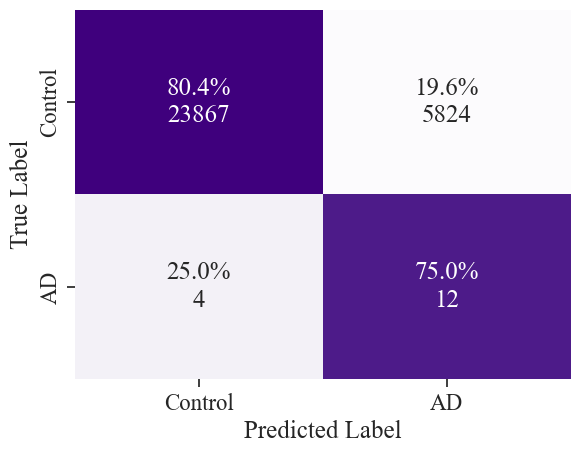

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.73it/s]

sensitivity,specificity,precision,ppv,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score
0.75 [0.56-0.95],0.8 [0.8-0.81],0.0 [0.0-0.0],0.0 [0.0-0.0],1.0 [1.0-1.0],0.25 [0.05-0.44],0.75 [0.56-0.95],0.2 [0.19-0.2],0.8 [0.8-0.81],1.0 [1.0-1.0],0.8 [0.8-0.81],0.78 [0.68-0.88],0.0 [0.0-0.01]
N= 29707 16


In [47]:
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(ad_y_rep_true, ad_y_rep_pred.ravel())
fig, ax = plt.subplots()
cm_analysis(ad_y_rep_true, np.array(ad_y_rep_pred > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'AD'], ymap=None, cmap='Purples', ax=ax)
plt.show()
y_test = ad_y_rep_true
y_probas = np.concatenate([1-ad_y_rep_pred.reshape((-1, 1)), ad_y_rep_pred.reshape((-1, 1))], axis=1)
get_all_metrics_cis(y_test, y_probas, max_distance_at)

In [ ]:
# do this for survival analysis
# don't use these cases at which image is collect (it is diagnostic and we don't care about it)

In [88]:
np.percentile(ad_y_rep_pred, 0.1)

0.01575141525

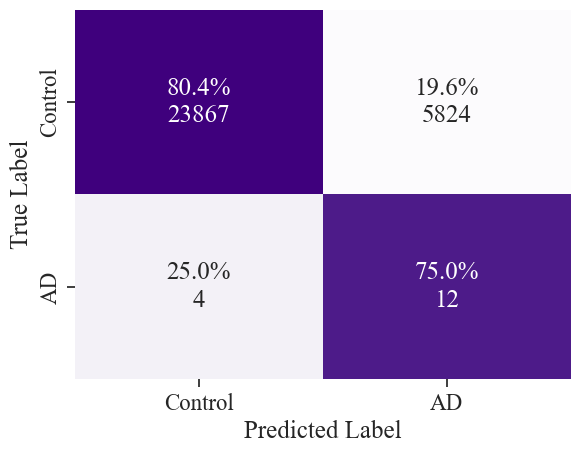

In [100]:
# sel_indexes = np.argsort(ad_y_rep_pred)[-10000:]
sel_indexes = np.argsort(ad_y_rep_pred)[::-1]# [:10000]
# sel_ad_y_rep_true = ad_y_rep_true[sel_indexes]
# sel_ad_y_rep_pred = ad_y_rep_pred[sel_indexes]

p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(ad_y_rep_true[sel_indexes], ad_y_rep_pred[sel_indexes].ravel())
# max_distance_at = np.percentile(ad_y_rep_pred, 0.99)
fig, ax = plt.subplots()
cm_analysis(ad_y_rep_true[sel_indexes], np.array(ad_y_rep_pred[sel_indexes] > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'AD'], ymap=None, cmap='Purples', ax=ax)
plt.show()
# y_test = sel_ad_y_rep_true
# y_probas = np.concatenate([1-sel_ad_y_rep_pred.reshape((-1, 1)), sel_ad_y_rep_pred.reshape((-1, 1))], axis=1)
# get_all_metrics_cis(y_test, y_probas, max_distance_at)

In [102]:
ad_y_rep_pred

array([0.02314794, 0.192546  , 0.4369421 , ..., 0.02583053, 0.1713992 ,
       0.09926122])

In [103]:
max_distance_at

0.19252044

In [94]:
len(ad_y_rep_true)

29707

In [95]:
(15 / (15 + 26721)), (15 + 1)/(len(ad_y_rep_true))

(0.0005610412926391383, 0.00053859359746861)

In [85]:
np.sort(ad_y_rep_pred)[1000]# [::-1][:10000]

0.021333091

In [82]:
max_distance_at

0.19252044

In [79]:
(12 / (12 + 5824)), (12)/(4164 + 5824 + 12)

(0.00205620287868403, 0.0012)

In [80]:
0.00205620287868403 / 0.0012

1.7135023989033586

In [64]:
ad_y_rep_pred

array([0.02314794, 0.192546  , 0.4369421 , ..., 0.02583053, 0.1713992 ,
       0.09926122])

In [65]:
(12 / (12 + 5824)), (12 + 4)/(23867 + 5824 + 12 + 4)

(0.00205620287868403, 0.00053859359746861)

In [66]:
0.00205620287868403/100

2.05620287868403e-05

In [67]:
# prevanlence_adjusted_ppv = 

In [68]:
(12 / (12 + 5824)), (12 + 4)/(23867 + 5824 + 12 + 4)

(0.00205620287868403, 0.00053859359746861)

In [69]:
0.00205620287868403 / 0.00053859359746861

3.8177261823166555

In [50]:
met=[ metrics.roc_auc_score]
X_metrics_cm = raw_metric_samples(met, ad_y_rep_true, ad_y_rep_pred, nboots=1000)
ci_mean = defaultdict(list)

mean_auc = metrics.roc_auc_score(ad_y_rep_true, ad_y_rep_pred) 
temp = X_metrics_cm.loc['Roc Auc'].values - mean_auc
ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
ci_mean['Roc Auc'].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")

ci_mean = pd.DataFrame(ci_mean)
print (','.join(ci_mean.columns))
print (','.join(ci_mean.iloc[0]))
print ("N =", len(y_test), sum(y_test))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.67it/s]

Roc Auc
0.76 [0.62-0.91]
N = 29707 16


In [51]:
met=[ metrics.roc_auc_score]
cix = ci(met, ad_y_rep_true, ad_y_rep_pred, nboots=1000)
print (metrics.roc_auc_score(ad_y_rep_true, ad_y_rep_pred))
cix

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.37it/s]

0.7559445623252837


1000 Boot Samples,Point Estim,2.5%ile,97.5%ile
Metric (class 1 +ve),,,
Roc Auc,0.755945,0.608973,0.891398


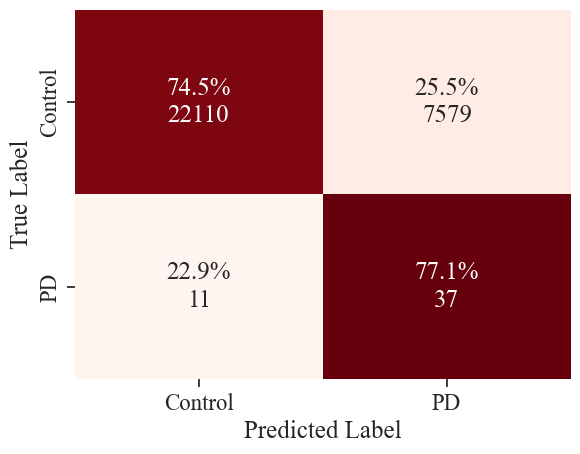

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.51it/s]

sensitivity,specificity,precision,ppv,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score
0.77 [0.65-0.89],0.74 [0.74-0.75],0.0 [0.0-0.01],0.0 [0.0-0.01],1.0 [1.0-1.0],0.23 [0.11-0.35],0.77 [0.65-0.89],0.26 [0.25-0.26],0.74 [0.74-0.75],1.0 [0.99-1.0],0.74 [0.74-0.75],0.76 [0.7-0.82],0.01 [0.01-0.01]
N= 29737 48


In [70]:
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(pd_y_rep_true, pd_y_rep_pred.ravel())
fig, ax = plt.subplots()
cm_analysis(pd_y_rep_true, np.array(pd_y_rep_pred > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'PD'], ymap=None, cmap='Reds', ax=ax)
plt.show()
y_test = pd_y_rep_true
y_probas = np.concatenate([1-pd_y_rep_pred.reshape((-1, 1)), pd_y_rep_pred.reshape((-1, 1))], axis=1)
get_all_metrics_cis(y_test, y_probas, max_distance_at)

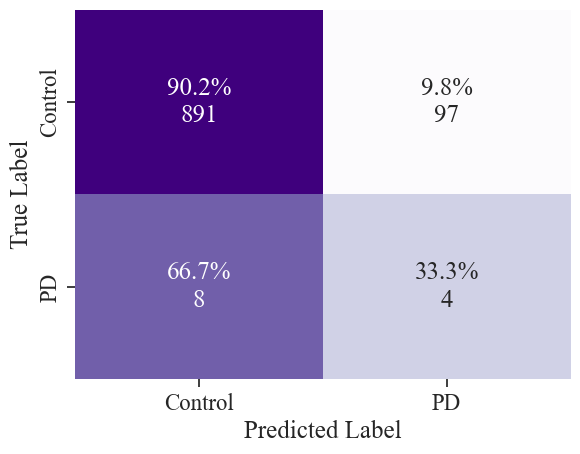

In [76]:
sel_indexes = np.argsort(pd_y_rep_pred)[::-1][:1000]
# sel_ad_y_rep_true = ad_y_rep_true[sel_indexes]
# sel_ad_y_rep_pred = ad_y_rep_pred[sel_indexes]

p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(pd_y_rep_true[sel_indexes], pd_y_rep_pred[sel_indexes].ravel())
fig, ax = plt.subplots()
cm_analysis(pd_y_rep_true[sel_indexes], np.array(pd_y_rep_pred[sel_indexes] > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'PD'], ymap=None, cmap='Purples', ax=ax)
plt.show()

In [74]:
(26 / (26 + 3005)), (26 + 11)/(3005 + 26 + 11 + 6958)

(0.008578027053777632, 0.0037)

In [75]:
0.0085/0.0037

2.2972972972972974

In [2]:
(37 / (37 + 7579)), (37 + 11)/(22110 + 7579 + 37 + 11)

(0.0048581932773109245, 0.0016141507213236037)

In [4]:
0.0048581932773109245 / 0.0016141507213236037

3.0097519476540615

In [53]:
met=[ metrics.roc_auc_score]
X_metrics_cm = raw_metric_samples(met, pd_y_rep_true, pd_y_rep_pred, nboots=1000)
ci_mean = defaultdict(list)

mean_auc = metrics.roc_auc_score(pd_y_rep_true, pd_y_rep_pred) 
temp = X_metrics_cm.loc['Roc Auc'].values - mean_auc
ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
ci_mean['Roc Auc'].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")

ci_mean = pd.DataFrame(ci_mean)
print (','.join(ci_mean.columns))
print (','.join(ci_mean.iloc[0]))
print ("N =", len(pd_y_rep_true), sum(pd_y_rep_true))
print ("N =", len(y_test), sum(y_test))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.03it/s]

Roc Auc
0.79 [0.72-0.86]
N = 29737 48
N = 29737 48


In [54]:
met=[ metrics.roc_auc_score]
cix = ci(met, pd_y_rep_true, pd_y_rep_pred, nboots=1000)
print (metrics.roc_auc_score(pd_y_rep_true, pd_y_rep_pred))
cix

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.04it/s]


0.7880380780760552


1000 Boot Samples,Point Estim,2.5%ile,97.5%ile
Metric (class 1 +ve),,,
Roc Auc,0.788038,0.706503,0.855189


# EXTRAS DONE HERE

In [55]:
ensembled_prediction = pd.read_csv("data/pd_ensembled_prediction.csv")
full_list_d = [[], []]
for fold in ['fold1', 'fold2', 'fold3']:
    temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
    full_list_d[0].append((temp['ensemble-y_pred1'].values, temp['y_true'].values))

# for fold in ['fold1', 'fold2', 'fold3']:
#     temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
#     full_list_d[1].append((1 - temp['ensemble-y_pred0'].values, temp['y_true'].values))
    
y_test = ensembled_prediction['y_true'].values
y_probas = ensembled_prediction[['ensemble-y_pred0', 'ensemble-y_pred1']].values

disease = 'PD'
duration_col = f"daysFromDiagnosis_image_taken_{disease}"
data[duration_col] = data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']
data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values
input_data = data[~(data[duration_col] >= 0)].copy()
temp_input_data = data.copy()
event_subjects = temp_input_data[temp_input_data[duration_col] <= 0].index
event_subjects_data = temp_input_data.loc[event_subjects].copy()
event_subjects_data[f"Status_{duration_col}"] = 1
right_censored_subjects = temp_input_data[(temp_input_data[duration_col].isnull()) & (temp_input_data['Age_at_image_taken'] >= 60)].index
right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
# right_censored_subjects_data = right_censored_subjects_data[right_censored_subjects_data['Age_at_image_taken'] >= 65]
right_censored_subjects_data[f"Status_{duration_col}"] = 0
F = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)
F = F.dropna(subset=[f"Status_{duration_col}", f"PD_imaging_score"])
y_rep_true = F[f"Status_{duration_col}"].values
y_rep_pred = F[f"PD_imaging_score"].values
full_list_d[1] = [(y_rep_pred, y_rep_true)]

In [56]:
len(full_list_d[0])

3

In [58]:
# palette_progression = {'Control':'orange', 'AD': 'blue'}
# class_labels = {0: 'AD', 1: 'Control'}
palette_progression = {'PD vs Control (PPMI):': 'red'}
class_labels = {0: 'PD vs Control (PPMI):'}

fig, ax = plt.subplots(1, 1, figsize=(8*1.2,6*1.2))
e = 0
# ax = axs.reshape(-1)[e]
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.despine(offset=5, trim=True)
# ax.spines['bottom'].set_visible(False)
plot_auc_roc(full_list_d[:1], (0, len(class_labels)), class_labels,  ax, show=True, addition='', palette_progression=palette_progression)
palette_progression = {'Replication (UKBB):': 'maroon'}
class_labels = {0: 'Replication (UKBB):'}
plot_auc_roc(full_list_d[1:], (0, len(class_labels)), class_labels,  ax, show=True, addition='', palette_progression=palette_progression)
# ax.set_title("3-fold CV ADNI (AD vs Control)")
fig.savefig('Step2_ml_model/Figure2_pd_auroc.png', dpi=100, bbox_inches = "tight")
fig.savefig('Step2_ml_model/Figure2_pd_auroc.pdf', dpi=100, bbox_inches = "tight")

AUCS 0.6433 [0.5643-0.7224] 0.64 [0.61-0.68]
AUCS 0.788 [nan-nan] 0.79 [0.79-0.79]


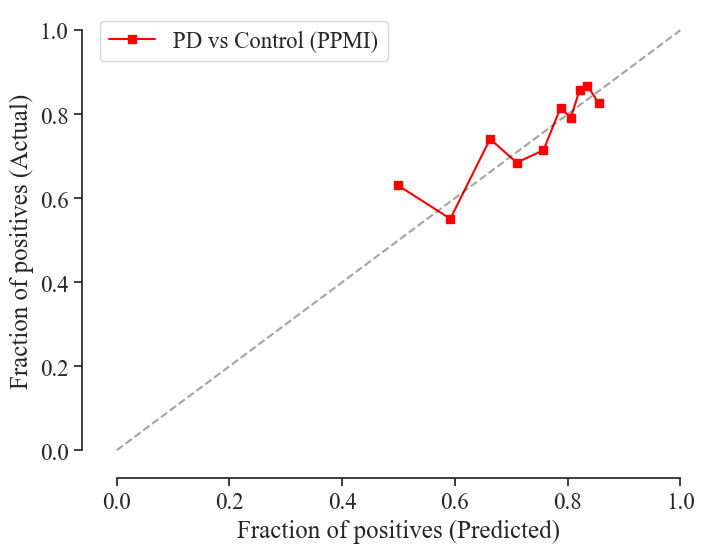

In [62]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test,y_probas[:,1],n_bins=10,strategy='quantile')
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax1.plot(prob_pred, prob_true, 's-', c='red', label='PD vs Control (PPMI)')
ax1.plot([0, 1], [0, 1], 'k--', alpha=.4)
ax1.set_xlabel('Fraction of positives (Predicted)')
ax1.set_ylabel('Fraction of positives (Actual)')
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc='upper left', ncol=1)
# ax1.set_title('Calibration Plots (Reliability Curve)')
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.despine(offset=5, trim=True)
plt.show()

In [63]:
import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve
decision_threshold = None
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_test, y_probas[:, 1].ravel())
if decision_threshold is None:
    decision_threshold = max_distance_at
print ('Dthreshold', decision_threshold)
fig = cm_analysis(y_test, np.array(y_probas[:, 1] > decision_threshold), filename=None, labels=[0, 1], classes=['Control', 'PD'], ymap=None, cmap='Reds', figsize=(6,6))
fig.savefig('Step2_ml_model/Figure2_pd_confusion_matrix.png', dpi=100, bbox_inches = "tight")
fig.savefig('Step2_ml_model/Figure2_pd_confusion_matrix.pdf', dpi=100, bbox_inches = "tight")

Dthreshold 0.77635056


TypeError: cm_analysis() missing 1 required positional argument: 'ax'

In [1162]:
mapping_scores = []
for fold in ['fold1', 'fold2', 'fold3']:
    temp = ensembled_prediction[ensembled_prediction['fold'] == fold]
    # p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(temp['y_true'].values, temp['ensemble-y_pred1'].values.ravel())
    # print (max_distance_at)
    # tn, fp, fn, tp = confusion_matrix(temp['y_true'].values, np.array(temp['ensemble-y_pred1'].values > max_distance_at)).ravel()
    tn, fp, fn, tp = confusion_matrix(temp['y_true'].values, np.array(temp['ensemble-y_pred1'].values > decision_threshold)).ravel()
    print (get_alls(tn, fp, fn, tp))
    mapping_scores.append(get_alls(tn, fp, fn, tp))

{'sensitivity': 0.6510638297872341, 'specificity': 0.5526315789473685, 'precision': 0.8181818181818182, 'npv': 0.3387096774193548, 'fnr': 0.34893617021276596, 'tpr': 0.651063829787234, 'fpr': 0.4473684210526316, 'tnr': 0.5526315789473684, 'fdr': 0.18181818181818182, 'acc': 0.6270096463022508, 'bal_acc': 0.6018477043673012, 'f1score': 0.7251184834123223}
{'sensitivity': 0.6304347826086957, 'specificity': 0.7012987012987013, 'precision': 0.8630952380952381, 'npv': 0.38848920863309355, 'fnr': 0.3695652173913043, 'tpr': 0.6304347826086957, 'fpr': 0.2987012987012987, 'tnr': 0.7012987012987013, 'fdr': 0.13690476190476192, 'acc': 0.6482084690553745, 'bal_acc': 0.6658667419536985, 'f1score': 0.7286432160804021}
{'sensitivity': 0.7918552036199095, 'specificity': 0.5, 'precision': 0.8101851851851852, 'npv': 0.47126436781609193, 'fnr': 0.2081447963800905, 'tpr': 0.7918552036199095, 'fpr': 0.5, 'tnr': 0.5, 'fdr': 0.18981481481481483, 'acc': 0.7128712871287128, 'bal_acc': 0.6459276018099547, 'f1sco

In [1163]:
types_scores = ['sensitivity', 'specificity', 'precision', 'npv', 'fnr', 'tpr', 'fpr', 'tnr', 'fdr', 'acc', 'bal_acc', 'f1score']
for stype in types_scores:
    print (stype, f_ci([mapping_scores[i][stype] for i in range(len(mapping_scores))]), f_std([mapping_scores[i][stype] for i in range(len(mapping_scores))]))

sensitivity 0.69 [0.47-0.91] 0.69 [0.62-0.76]
specificity 0.58 [0.33-0.84] 0.58 [0.5-0.67]
precision 0.83 [0.76-0.9] 0.83 [0.81-0.85]
npv 0.4 [0.23-0.57] 0.4 [0.34-0.45]
fnr 0.31 [0.09-0.53] 0.31 [0.24-0.38]
tpr 0.69 [0.47-0.91] 0.69 [0.62-0.76]
fpr 0.42 [0.16-0.67] 0.42 [0.33-0.5]
tnr 0.58 [0.33-0.84] 0.58 [0.5-0.67]
fdr 0.17 [0.1-0.24] 0.17 [0.15-0.19]
acc 0.66 [0.55-0.77] 0.66 [0.63-0.7]
bal_acc 0.64 [0.56-0.72] 0.64 [0.61-0.66]
f1score 0.75 [0.65-0.86] 0.75 [0.72-0.79]


0.77937764


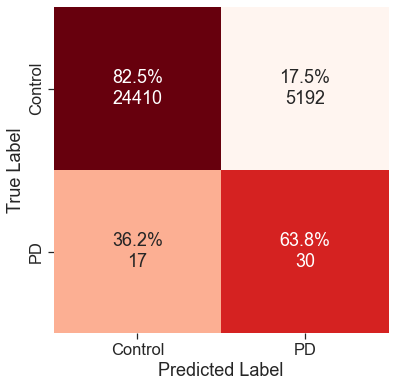

In [1164]:
p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_rep_true, y_rep_pred.ravel())
print (max_distance_at)
fig = cm_analysis(y_rep_true, np.array(y_rep_pred > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'PD'], ymap=None, cmap='Reds', figsize=(6,6))

In [1165]:
tn, fp, fn, tp = confusion_matrix(y_rep_true, np.array(y_rep_pred > max_distance_at)).ravel()
print (get_alls(tn, fp, fn, tp))

{'sensitivity': 0.6382978723404256, 'specificity': 0.8246064455104385, 'precision': 0.005744925315970892, 'npv': 0.9993040487984607, 'fnr': 0.3617021276595745, 'tpr': 0.6382978723404256, 'fpr': 0.1753935544895615, 'tnr': 0.8246064455104385, 'fdr': 0.9942550746840291, 'acc': 0.824311106614051, 'bal_acc': 0.731452158925432, 'f1score': 0.011387360030366294}


In [1166]:
Z = F[['Sex', 'Age_at_image_taken', 'townsend', 'PD_prs', 'norm_PD_imaging_score', f"Status_{duration_col}"]].copy()
Z = Z.dropna()

In [1167]:
features_combination = [
    ['Age_at_image_taken', 'Sex', 'townsend'],
    ['Age_at_image_taken', 'Sex', 'townsend', 'PD_prs'],
    ['Age_at_image_taken', 'Sex', 'townsend', 'PD_prs', 'norm_PD_imaging_score'],
    # ['norm_PD_imaging_score', 'Age_at_image_taken', 'Sex'],
    # ['norm_PD_imaging_score', 'Age_at_image_taken', 'Sex', 'PD_prs', 'townsend'],
]

In [1168]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
full_list_d_modality = []
for e, features in enumerate(features_combination):
    print ("input_features", features)
    X = Z[features].values
    y = Z[[f"Status_{duration_col}"]].values
    skf = StratifiedKFold(n_splits=5)
    aucs_list = []
    temp = []
    mapping_scores_temp = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_fold, y_fold = X[train_index], y[train_index].ravel()
        X_fold_test, y_fold_test = X[test_index], y[test_index].ravel()
        clf = LogisticRegression(random_state=0).fit(X_fold, y_fold)
        auc_score = roc_auc_score(y_fold_test, clf.predict_proba(X_fold_test)[:, 1])
        temp.append((clf.predict_proba(X_fold_test)[:, 1], y_fold_test))
        
        p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_fold_test, clf.predict_proba(X_fold_test)[:, 1].ravel())
        tn, fp, fn, tp = confusion_matrix(y_fold_test, np.array( clf.predict_proba(X_fold_test)[:, 1] > max_distance_at)).ravel()
        mapping_scores_temp.append(get_alls(tn, fp, fn, tp))        
        aucs_list.append(auc_score)
    
    types_scores = ['sensitivity', 'specificity', 'precision', 'npv', 'fnr', 'tpr', 'fpr', 'tnr', 'fdr', 'acc', 'bal_acc', 'f1score']
    for stype in types_scores:
        print (stype, f_ci([mapping_scores_temp[i][stype] for i in range(len(mapping_scores_temp))]), f_std([mapping_scores_temp[i][stype] for i in range(len(mapping_scores_temp))]))

    full_list_d_modality.append(temp)
    print (f_ci(aucs_list), f_std(aucs_list), f_iqr(aucs_list))
    

input_features ['Age_at_image_taken', 'Sex', 'townsend']
sensitivity 0.71 [0.5-0.93] 0.71 [0.56-0.87]
specificity 0.57 [0.37-0.77] 0.57 [0.43-0.72]
precision 0.0 [0.0-0.0] 0.0 [0.0-0.0]
npv 1.0 [1.0-1.0] 1.0 [1.0-1.0]
fnr 0.29 [0.07-0.5] 0.29 [0.13-0.44]
tpr 0.71 [0.5-0.93] 0.71 [0.56-0.87]
fpr 0.43 [0.23-0.63] 0.43 [0.28-0.57]
tnr 0.57 [0.37-0.77] 0.57 [0.43-0.72]
fdr 1.0 [1.0-1.0] 1.0 [1.0-1.0]
acc 0.57 [0.38-0.77] 0.57 [0.43-0.72]
bal_acc 0.64 [0.55-0.74] 0.64 [0.57-0.71]
f1score 0.01 [0.0-0.01] 0.01 [0.0-0.01]
0.58 [0.45-0.72] 0.58 [0.49-0.68] 0.58 [0.55-0.62]
input_features ['Age_at_image_taken', 'Sex', 'townsend', 'PD_prs']
sensitivity 0.74 [0.59-0.89] 0.74 [0.63-0.85]
specificity 0.66 [0.48-0.84] 0.66 [0.54-0.79]
precision 0.0 [0.0-0.01] 0.0 [0.0-0.0]
npv 1.0 [1.0-1.0] 1.0 [1.0-1.0]
fnr 0.26 [0.11-0.41] 0.26 [0.15-0.37]
tpr 0.74 [0.59-0.89] 0.74 [0.63-0.85]
fpr 0.34 [0.16-0.52] 0.34 [0.21-0.46]
tnr 0.66 [0.48-0.84] 0.66 [0.54-0.79]
fdr 1.0 [0.99-1.0] 1.0 [1.0-1.0]
acc 0.66 [0.49

In [1169]:
# full_list_d_modality[0]

AUCS 0.58 [0.45-0.72] 0.58 [0.55-0.62]
AUCS 0.69 [0.58-0.8] 0.69 [0.66-0.72]
AUCS 0.79 [0.7-0.88] 0.79 [0.74-0.84]


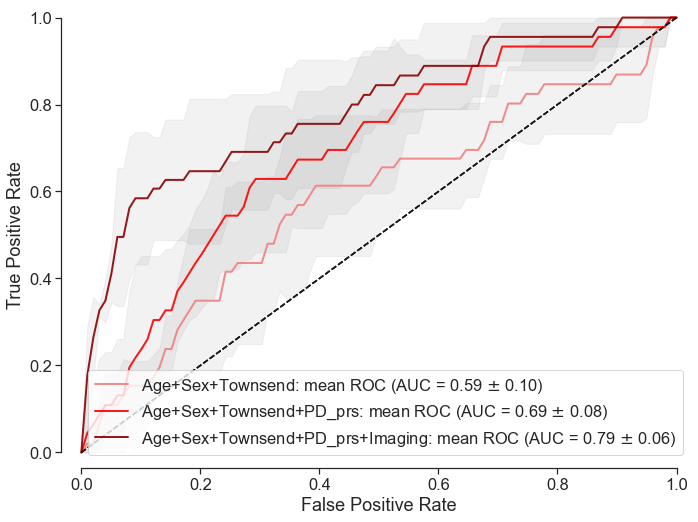

In [1170]:
# palette_progression = {'Control':'orange', 'AD': 'blue'}
# class_labels = {0: 'AD', 1: 'Control'}
palette_progression = {'Age+Sex+Townsend:': 'lightcoral'}
class_labels = {0: 'Age+Sex+Townsend:'}
fig, ax = plt.subplots(1, 1, figsize=(8*1.4,6*1.4))
e = 0
# ax = axs.reshape(-1)[e]
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
sns.despine(offset=5, trim=True)
# ax.spines['bottom'].set_visible(False)
plot_auc_roc(full_list_d_modality[:1], (0, len(class_labels)), class_labels,  ax, show=True, addition='', palette_progression=palette_progression)
palette_progression = {'Age+Sex+Townsend+PD_prs:': 'red'}
class_labels = {0: 'Age+Sex+Townsend+PD_prs:'}
plot_auc_roc(full_list_d_modality[1:2], (0, len(class_labels)), class_labels,  ax, show=True, addition='', palette_progression=palette_progression)
palette_progression = {'Age+Sex+Townsend+PD_prs+Imaging:': 'darkred'}
class_labels = {0: 'Age+Sex+Townsend+PD_prs+Imaging:'}
plot_auc_roc(full_list_d_modality[2:], (0, len(class_labels)), class_labels,  ax, show=True, addition='', palette_progression=palette_progression)

# ax.set_title("3-fold CV ADNI (AD vs Control)")
fig.savefig('Figure2/Figure2_pd_auroc_multimodal.png', dpi=100, bbox_inches = "tight")
fig.savefig('Figure2/Figure2_pd_auroc_multimodal.pdf', dpi=100, bbox_inches = "tight")